In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore')



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.11.0


In [2]:
IMAGE_SIZE = [176, 176]

In [3]:
data = np.load("/kaggle/input/data-weights/Variables.npz")

In [4]:
train_data, test_data, train_labels, test_labels, val_data, val_labels = [data[key] for key in data.files]

In [5]:
print(f'Training Size : {train_data.shape} | Training Labels : {train_labels.shape}')
print(f'Validation Size : {val_data.shape} | Validation Labels : {val_labels.shape}')
print(f'Testing Size : {test_data.shape}   |  Testing Labels : {test_labels.shape}')

Training Size : (7787, 176, 176, 3) | Training Labels : (7787, 4)
Validation Size : (2197, 176, 176, 3) | Validation Labels : (2197, 4)
Testing Size : (2816, 176, 176, 3)   |  Testing Labels : (2816, 4)


In [24]:
import gc
gc.collect()

23

In [8]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 1s 0us/step


In [10]:
for layer in inception_model.layers:
    layer.trainable=False

In [11]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [12]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [13]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [16]:
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100


2023-04-09 03:37:27.021250: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ininception_cnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


244/244 [==============================] - 32s 77ms/step - loss: 1.4150 - acc: 0.3927 - auc: 0.6644 - f1_score: 0.3874 - val_loss: 0.9213 - val_acc: 0.5849 - val_auc: 0.8467 - val_f1_score: 0.5486 - lr: 0.0010
Epoch 2/100
244/244 [==============================] - 13s 52ms/step - loss: 0.9455 - acc: 0.5647 - auc: 0.8354 - f1_score: 0.5523 - val_loss: 0.7526 - val_acc: 0.6340 - val_auc: 0.8917 - val_f1_score: 0.6147 - lr: 0.0010
Epoch 3/100
244/244 [==============================] - 16s 64ms/step - loss: 0.8204 - acc: 0.6268 - auc: 0.8784 - f1_score: 0.6126 - val_loss: 0.7042 - val_acc: 0.6655 - val_auc: 0.9068 - val_f1_score: 0.6548 - lr: 0.0010
Epoch 4/100
244/244 [==============================] - 15s 63ms/step - loss: 0.7527 - acc: 0.6608 - auc: 0.8969 - f1_score: 0.6524 - val_loss: 0.6548 - val_acc: 0.6955 - val_auc: 0.9198 - val_f1_score: 0.6776 - lr: 0.0010
Epoch 5/100
244/244 [==============================] - 13s 53ms/step - loss: 0.7141 - acc: 0.6834 - auc: 0.9081 - f1_score: 

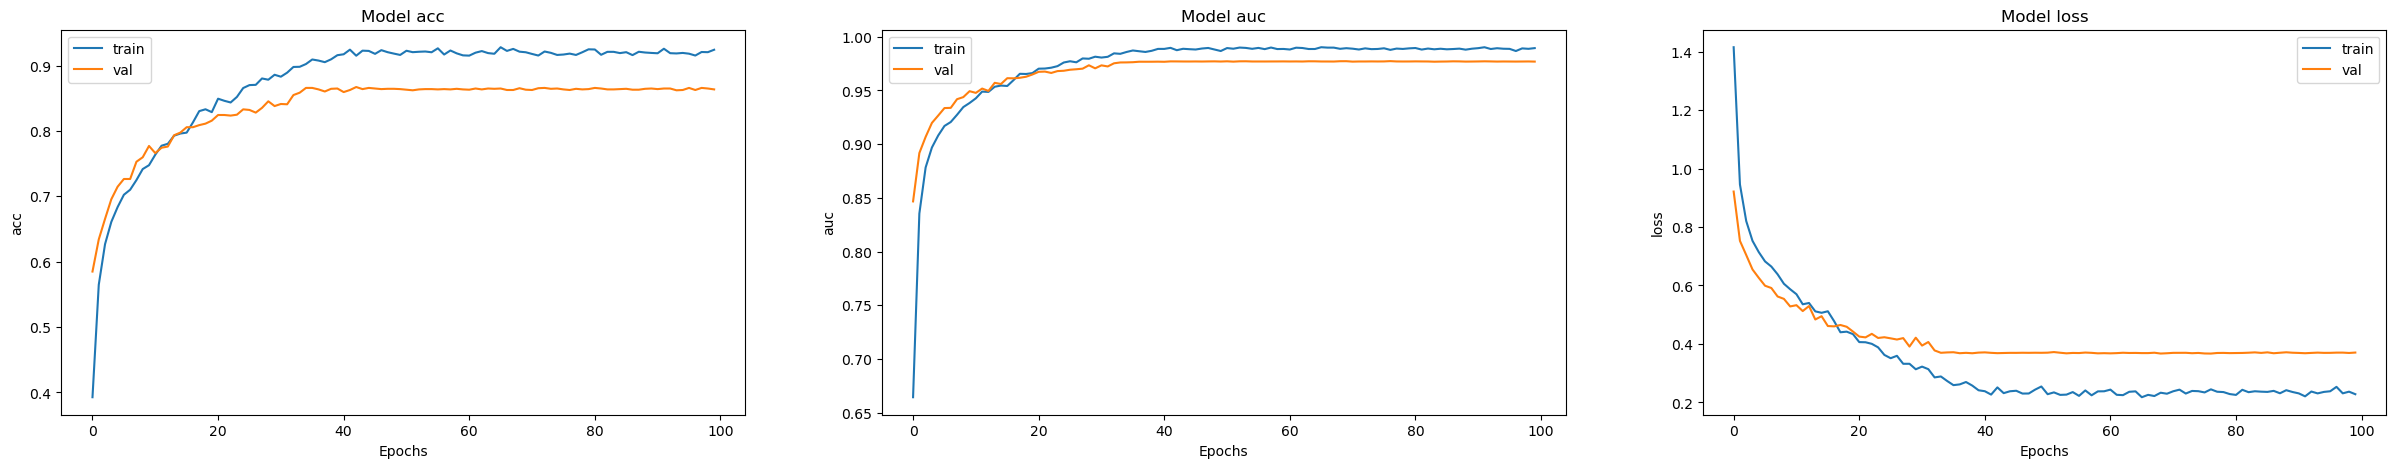

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
model2 = custom_inception_model

In [22]:
train_scores = model2.evaluate(train_data, train_labels)
val_scores = model2.evaluate(val_data, val_labels)
test_scores = model2.evaluate(test_data, test_labels)

88/88 [==============================] - 4s 43ms/step - loss: 0.3803 - acc: 0.8491 - auc: 0.9761 - f1_score: 0.8484


In [25]:
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

Training Accuracy: 99.28%
Validation Accuracy: 86.35%
Testing Accuracy: 84.91%


In [26]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

pred_labels = model2.predict(test_data)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

88/88 [==============================] - 5s 36ms/step
                  precision    recall  f1-score   support

     NonDemented       0.88      0.93      0.91       714
VeryMildDemented       0.99      1.00      1.00       692
    MildDemented       0.76      0.75      0.76       686
ModerateDemented       0.75      0.72      0.73       724

       micro avg       0.85      0.85      0.85      2816
       macro avg       0.85      0.85      0.85      2816
    weighted avg       0.85      0.85      0.85      2816
     samples avg       0.85      0.85      0.85      2816



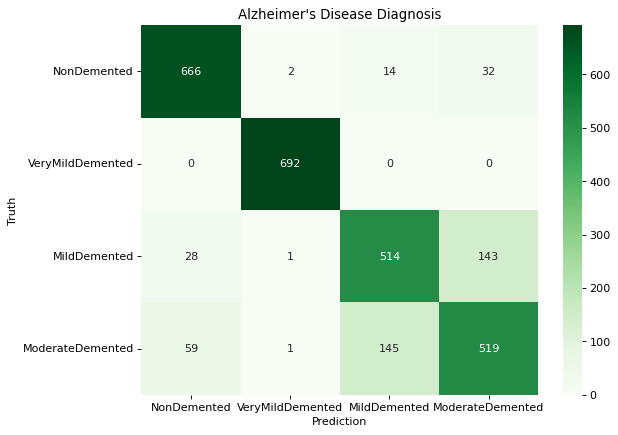

In [27]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [28]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 84.97 %
Matthew's Correlation Coefficient: 79.89 %


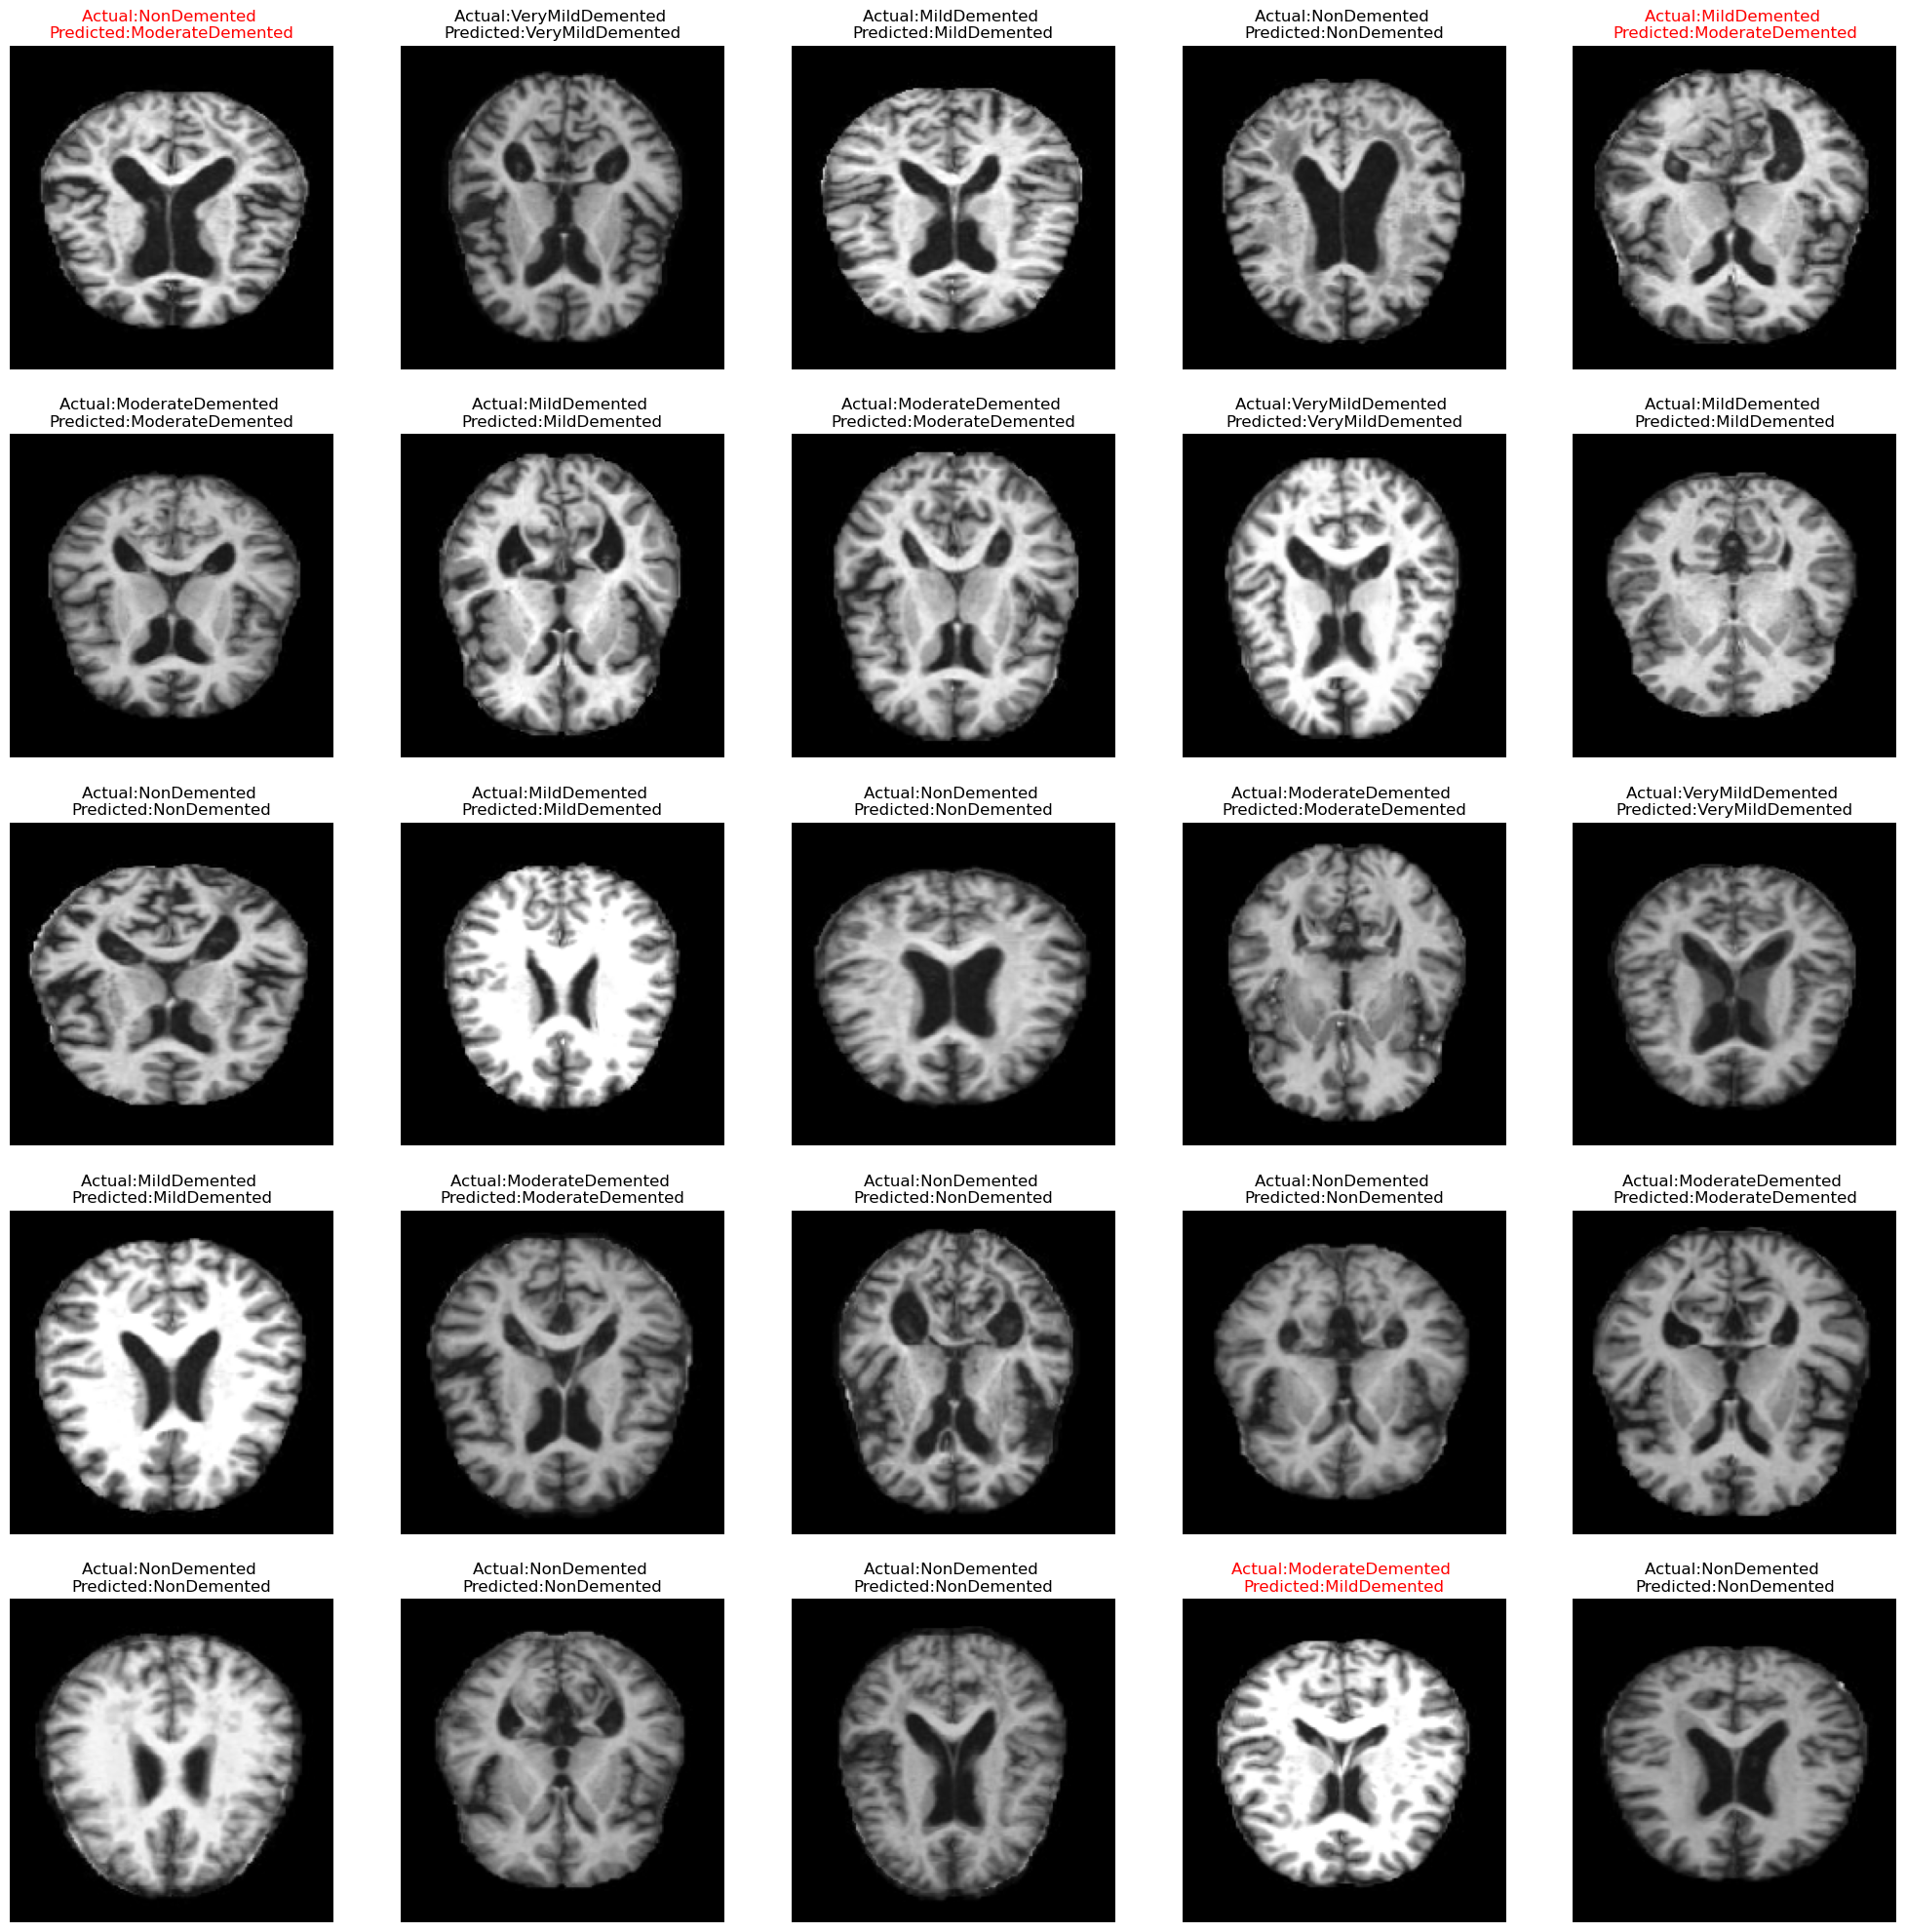

In [29]:
labels = dict(zip([0,1,2,3], CLASSES))
plt.figure(figsize=(25, 25))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(test_data[i])
    plt.axis("off")
    
    if np.argmax(test_labels[i]) != np.argmax(pred_labels[i]):
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]), 
                  color='red')
    else:
        plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(test_labels[i])],labels[np.argmax(pred_labels[i])]))

In [31]:
gc.collect()

23

In [32]:
model_dir = "./Model " + "Model_Incpetion"
model2.save(model_dir, save_format='h5')

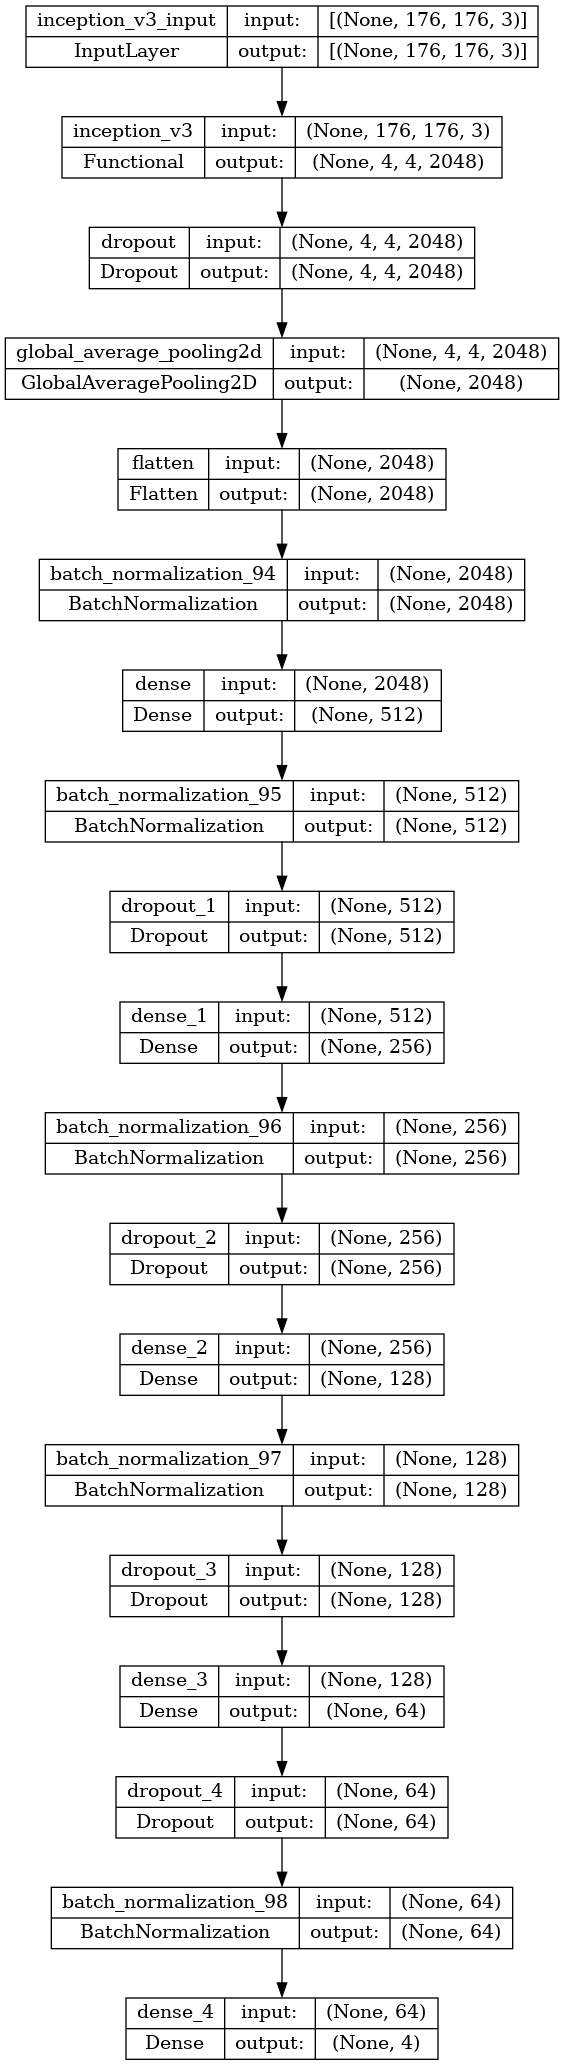

In [34]:
#Check its architecture
plot_model(model2, to_file='/Model' + "model_plot.png", show_shapes=True, show_layer_names=True)